[![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/aws/sagemaker/sagemaker-pinecone-rag.ipynb)

# Module 01 - Data Loading


This module contains notebook code to:
* Create the Pinecone Index
* Parse the data
* Convert to vectors - chunking & embedding
* Upload the vectors to Pinecone


### Install required libraries

In [1]:
%pip install --quiet --upgrade \
    pinecone-notebooks \
    pinecone \
    tqdm \
    boto3 \
    botocore

Note: you may need to restart the kernel to use updated packages.


To begin, we will initialize Amazon Bedrock and Pinecone that we'll need to use throughout the walkthrough.

In [2]:
# Standard library imports
import re
import time
import getpass
import json

# Third-party imports
from tqdm import tqdm

# Pinecone and Rich libraries
from pinecone import Pinecone
from pinecone import ServerlessSpec

# AWS Library imports
import boto3
from botocore.config import Config

### Initialize Pinecone

In [ ]:
PINECONE_API_KEY = getpass.getpass("Enter Pinecone API Key")
pc = Pinecone(api_key=PINECONE_API_KEY, source_tag="pinecone:agentic_ai_with_pinecone_and_aws:notebooks:1_data_loading_pipeline")

In [ ]:
index_name = 'agentic-ai-with-pinecone-and-aws'
namespace = '__default__' # Namespaces are used to organize data in Pinecone, like for multi-tenant applications. We'll use the default namespace for this workshop.

In [5]:
spec = ServerlessSpec(cloud='aws', region='us-east-1') #Provide Pinecone region that we selected in the 'Create Pinecone Index' section

### Setup AWS environment

If you're running this workshop as part of a Pinecone-hosted event, the Jupyter environment only has access to `BEDROCK_ACCESS_KEY` and `BEDROCK_SECRET_KEY`, so we need to assign these to the default keys that the Bedrock client will read from the environment.

If you are not running this as part of a Pinecone-hosted event, there is no need to run this next step and you can skip to the Bedrock client initialization.

In [ ]:
import os

# Set correct env vars because Instruqt workshop uses different keys
#
# Comment these two lines out if you are not running in
# this in a Pinecone-hosted workshop event
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('BEDROCK_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('BEDROCK_SECRET_KEY')

### Initialize Bedrock

Now we can initialize the Bedrock client:

In [ ]:
config = Config(connect_timeout=5, read_timeout=60, retries={"total_max_attempts": 20, "mode": "adaptive"})
region = 'us-east-1'

bedrock = boto3.client(
                service_name='bedrock-runtime',
                region_name=region,
                endpoint_url=f'https://bedrock-runtime.{region}.amazonaws.com',
                                    config=config)

embedding_model_id = "amazon.titan-embed-text-v2:0"

### Create Pinecone Index

In [8]:
# get existing indexes
existing_indexes = pc.list_indexes().names()

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1024, # Must match the dimension of the embedding model
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)


In [9]:
# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
print(index.describe_index_stats())

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'agentic-rag': {'vector_count': 880}},
 'total_vector_count': 880,
 'vector_type': 'dense'}


### Loading the data

Let us parse the raw data and store it into the Pinecone Index. Below is the step-by-step process. For this workshop we will be using 10-K filings of Comapaq company from year 1994 to 2002 which are in text documents.

- Step 0. Load the data from the files
- Step 1. Parse the documents and extract the text 
- Step 2. Chunk the data and create vector embeddings
- Step 3. Upsert the vector embeddings into the Pinecone Index

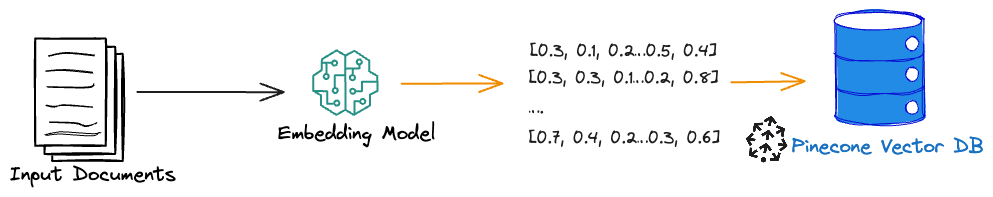

#### Step 0: Load the data from the files

First, unzip the agentic_ai_with_pinecone_and_aws_dataset.zip file present in the data folder.

⚠️ If you are running this as part of a Pinecone-hosted event, the data will already be unzipped for you.

Next, load each file:

In [ ]:
## Load Compaq's 10-K filings which are available in the data folder

filing_years = ['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002']
data_dir = '../data/agentic_ai_with_pinecone_and_aws_dataset'

In [11]:
texts = {
    year: open(f"{data_dir}/{year}.txt", encoding="utf-8").read()
    for year in filing_years
}

### Step 1: Parse the documents and extract the data


In [12]:
#Remove unwanted tags, extract tables, and split the data into manageable chunks:
def remove_unwanted_tags(text: str, keep_tags: list = None) -> str:
    """
    Remove all HTML/XML tags from text except for specified tags to keep.

    Args:
        text (str): Input text containing tags.
        keep_tags (list, optional): List of tag names to retain (without angle brackets).
                                    Defaults to ["TABLE"].

    Returns:
        str: Cleaned text with unwanted tags removed.
    """
    if keep_tags is None:
        keep_tags = ["TABLE"]
    keep_pattern = '|'.join(keep_tags)
    pattern = re.compile(rf'<(?!/?(?:{keep_pattern})\b)[^>]+>')
    return pattern.sub('', text)


def parse_10ks(year: str, document_text: str) -> str:
    """
    Extract and clean the text enclosed within <TEXT> tags of a 10-K filing.

    Args:
        year (str): The filing year.
        document_text (str): Raw text of the filing.

    Returns:
        str: Cleaned text within the <TEXT> tags, or an empty string if not found.
    """
    pattern = re.compile(r"<TEXT>(.*?)</TEXT>", re.DOTALL)
    matches = pattern.findall(document_text)
    if not matches:
        print(f"Document text not found for year {year}")
        return ""
    return remove_unwanted_tags(matches[0])

### Step 2: Chunk the data and create vector embeddings


In [13]:
#Split the document text into table sections and non-table text:
def chunk_by_table(document_text: str) -> dict:
    """
    Split document text into table and non-table parts.

    Args:
        document_text (str): Raw document text.

    Returns:
        dict: Dictionary with keys 'tables' (list of table sections)
              and 'texts' (concatenated non-table text).
    """
    chunks = {"tables": [], "texts": []}
    table_pattern = re.compile(r'(<TABLE.*?</TABLE>)', re.DOTALL | re.IGNORECASE)
    parts = table_pattern.split(document_text)

    for part in parts:
        if not part.strip():
            continue
        if table_pattern.match(part):
            chunks["tables"].append(part)
        else:
            chunks["texts"].append(part)

    chunks["texts"] = "".join(chunks["texts"])
    return chunks

test_table_chunking = chunk_by_table(texts['1996'])

print((test_table_chunking["tables"][0]))


<TABLE> <S> <C>

<ARTICLE> 5
<LEGEND>
THIS SCHEDULE CONTAINS SUMMARY FINANCIAL INFORMATION EXTRACTED FROM
COMPAQ COMPUTER CORPORATION'S CONSOLIDATED BALANCE SHEET AND CONSOLIDATED
STATEMENT OF INCOME FOR THE PERIOD ENDED DECEMBER 31, 1995 AND IS QUAILIFIED
IN ITS ENTIRETY BY REFERENCE TO SUCH FINANCIAL STATEMENTS.
</LEGEND>
<MULTIPLIER> 1,000,000
       
<S>                             <C>
<PERIOD-TYPE>                   YEAR
<FISCAL-YEAR-END>                          DEC-31-1995
<PERIOD-END>                               DEC-31-1995
<CASH>                                             745
<SECURITIES>                                         0
<RECEIVABLES>                                    3,241
<ALLOWANCES>                                       100
<INVENTORY>                                      2,156
<CURRENT-ASSETS>                                 6,527
<PP&E>                                           1,981
<DEPRECIATION>                                     871
<TOTAL-ASSETS>      

In [14]:
test_table_chunking = chunk_by_table(texts['1996'])

parse_10ks(1994, test_table_chunking["texts"])

'\n\n______________________________________________________________________\n\n                  SECURITIES AND EXCHANGE COMMISSION\n                        Washington, D.C. 20549\n\n                              FORM 10-K\n\n           ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF\n                 THE SECURITIES EXCHANGE ACT OF 1934\n\n             For the Fiscal Year Ended December 31, 1995\n\n                    Commission File Number 1-9026\n\n                     COMPAQ COMPUTER CORPORATION\n        (Exact name of registrant as specified in its charter)\n\n             Delaware                        76-0011617\n (State or other jurisdiction of          (I.R.S. Employer\n  incorporation or organization)        Identification No.)\n\n                  20555 SH 249, Houston, Texas 77070\n                            (713) 370-0670\n    (Address, including zip code, and telephone number, including\n       area code, of registrant\'s principal executive offices)\n\nSecurities regis

In [15]:
# split into table/not table

split_by_table = {
    year: chunk_by_table(text)
    for year, text in texts.items()
} 

In [16]:
# clean the non-table bits

clean_texts = {
    year: {"tables": chunk_data["tables"],
           "texts": parse_10ks(year, chunk_data["texts"])}
    for year, chunk_data in split_by_table.items()
}

In [17]:
#Text Chunking
CHAR_CHUNKS = 1500

def chunk_text(text: str, chunk_size: int) -> list:
    """
    Split text into chunks of a specified size.

    Args:
        text (str): The text to be split.
        chunk_size (int): Maximum number of characters per chunk.

    Returns:
        list: A list of text chunks.
    """
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

# chunk the texts, ignore the tables

chunked_texts = {
    year: {"tables": chunk_data["tables"],
           "texts": chunk_text(chunk_data["texts"], CHAR_CHUNKS)}
    for year, chunk_data in clean_texts.items()
}

In [18]:
print(chunked_texts['1995']['tables'])

["<TABLE> <S> <C>\n\n<PAGE>\n<ARTICLE> 5\n<LEGEND>\nTHIS SCHEDULE CONTAINS SUMMARY FINANCIAL INFORMATION EXTRACTED FROM\nCOMPAQ COMPUTER CORPORATION'S CONSOLIDATED BALANCE SHEET AND CONSOLIDATED\nSTATEMENT OF INCOME FOR THE PERIOD ENDED DECEMBER 31, 1994 AND IS QUAILIFIED\nIN ITS ENTIRETY BY REFERENCE TO SUCH FINANCIAL STATEMENTS.\n</LEGEND>\n<MULTIPLIER> 1,000,000\n       \n<S>                             <C>\n<PERIOD-TYPE>                   YEAR\n<FISCAL-YEAR-END>                          DEC-31-1994\n<PERIOD-END>                               DEC-31-1994\n<CASH>                                             471\n<SECURITIES>                                         0\n<RECEIVABLES>                                    2,362\n<ALLOWANCES>                                        75\n<INVENTORY>                                      2,005\n<CURRENT-ASSETS>                                 5,158\n<PP&E>                                           1,672\n<DEPRECIATION>                             

In [19]:
## Transforming the data into records

# reformat into records, make the ids for each chunk relate to the documentyear

base_string = "compaq"
# then, we add the document year and the chunk number to the base_string to create unique id

all_text_records = []
all_table_records = []

for year, chunks in chunked_texts.items():
    text_records = [
        {
            "chunk_text": chunk,
            "_id": f"{base_string}_{year}#text{num}",
            "filed_year": int(year),
            "chunk_type": "text"
        }
        for num, chunk in enumerate(chunks["texts"])
    ]
    table_records = [
        {
            "chunk_text": chunk,
            "_id": f"{base_string}_{year}#table{num}",
            "filed_year": int(year),
            "chunk_type": "table"
        }
        for num, chunk in enumerate(chunks["tables"])
    ]
    all_text_records.extend(text_records)
    all_table_records.extend(table_records)

### Step 3: Upsert the vector embeddings into the Pinecone Index


In [20]:
def text_embeddings(docs: list) -> list[float]:
    """
    Generate text embedding by using Amazon Bedrock and the amazon.titan-embed-text-v2:0.
    Args:
        docs: list of strings of text to embed.
    Returns:
        dict: embeddings in float type.
    """

    embeddings = []
    for doc in docs:
        body = json.dumps({"inputText": doc})

        response = bedrock.invoke_model(
            body=body,
            modelId=embedding_model_id,
        )

        response_body = json.loads(response.get('body').read())
        embedding = response_body.get('embedding')
        embeddings.append(embedding)

    return embeddings

In [21]:
# Embed in upsert into Pinecone 96 chunks at a time

def upsert_in_batches(records, batch_size=96):
    for i in tqdm(range(0, len(records), batch_size)):
        batch = records[i:i+batch_size]
        # Extract the record IDs for this batch
        record_ids = [record["_id"] for record in batch]

        # Fetch existing records from the index for these IDs.
        # (Assumes that the returned dict contains a "vectors" key with the current records.)
        existing = index.fetch(ids=record_ids, namespace=namespace)
        existing_ids = set(existing.vectors.keys())

        # Filter out records that already exist.
        records_to_upsert = [record for record in batch if record["_id"] not in existing_ids]

        if records_to_upsert:
            # Prepare batch of texts for embedding
            texts = [record["chunk_text"] for record in records_to_upsert]
            # Batch embedding
            embeds_list = text_embeddings(docs=texts)
            vectors = []
            for record, embeds in zip(records_to_upsert, embeds_list):
                vectors.append({
                    "id": record["_id"],
                    "values": embeds,
                    "metadata": {
                        "filed_year": record["filed_year"],
                        "chunk_type": record["chunk_type"],
                        "chunk_text": record["chunk_text"]
                    }
                })
            if vectors:
                index.upsert(vectors=vectors, namespace=namespace)
                time.sleep(0.5)


upsert_in_batches(all_text_records)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


In [22]:
# view index stats
print(index.describe_index_stats())

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'agentic-rag': {'vector_count': 880}},
 'total_vector_count': 880,
 'vector_type': 'dense'}
